## **Weed or Crop? Training a deep learning model to identify weed and crop species.**

Files are all located in Google Drive, so it is necessary to mount this into the notebook.

In [1]:
# Mount google drive where files are located
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Then set up libraries that will be needed.

In [2]:
# Set up 
import os
import keras

from keras import backend as K  
from keras import models
from keras import layers
from keras import optimizers

from keras.preprocessing.image import ImageDataGenerator

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

import tensorflow as tf
from tensorflow import one_hot
from tensorflow.keras.applications import xception
from tensorflow.keras.preprocessing import image

import gc
import glob

np.random.seed(5)

The directories for training, validation and test images are located within the base directory. These are defined here. 

In [3]:
# Define directories for training and test images
base_path = '/content/drive/MyDrive/Harper/3-C7082/Assignment/C7082-assignment/new-data'

train_data_path = os.path.join(base_path, 'train/')
val_data_path = os.path.join(base_path, 'validation/')
test_data_path = os.path.join(base_path, 'test/')


The list of species of plants in these directories is listed below, along with the number of images in each class. There are a different number of images in each class. 
There are 12 classes of plant, these abbreviated names are explained in the report.

In [4]:
list_paths = glob.glob(train_data_path + '*')
species = [i.replace(train_data_path,'') for i in list_paths]
print(species)


['bgs', 'chk', 'cls', 'cwd', 'cbl', 'wht', 'fhn', 'lsb', 'mze', 'smw', 'shp', 'sbt']


In [5]:
for i in species:
    print(i + ': ' + str(len(os.listdir(train_data_path + i))) + ' pictures')

bgs: 259 pictures
chk: 402 pictures
cls: 285 pictures
cwd: 663 pictures
cbl: 526 pictures
wht: 203 pictures
fhn: 488 pictures
lsb: 712 pictures
mze: 207 pictures
smw: 557 pictures
shp: 224 pictures
sbt: 413 pictures


In [ ]:
total_images = 0
for folder in subfolders:
    total_images += len(listdir(base_path + folder))

plantstate = pd.DataFrame(index=np.arange(0, total_images), columns=["width", "height", "species"])

k = 0
all_images = []
for m in range(len(subfolders)):
    folder = subfolders[m]
    
    images = listdir(base_path + folder)
    all_images.extend(images)
    n_images = len(images)
    
    for n in range(0, n_images):
        image = imread(base_path + folder + "/" + images[n])
        plantstate.loc[k, "width"] = image.shape[1]
        plantstate.loc[k, "height"] = image.shape[0]
        plantstate.loc[k, "species"] = folder
        plantstate.loc[k, "image_name"] = images[n]
        k+=1

plantstate.width = plantstate.width.astype(np.int)
plantstate.height = plantstate.height.astype(np.int)
plantstate.head()

In [ ]:
encoder = LabelEncoder()
labels = encoder.fit_transform(plantstate.species.values)
plantstate["target"] = labels
NUM_CLASSES = plantstate.target.nunique()
plantstate.head()

In [ ]:
fig, ax = plt.subplots(4,3,figsize=(20,25))

for m in range(4):
    for n in range(3):
        folder = subfolders[m+n*4]
        files = listdir(base_path + folder + "/")
        image = imread(base_path + folder + "/" + files[0])
        ax[m,n].imshow(image)
        ax[m,n].grid(False)
        ax[m,n].set_title(folder + "/" + str(m+n*4+1))

# MODEL 1

For this model, transfer learning will be implemented. The Xception base was decided on as it shows high accuracy when compared to other models on similar image classification problems.

The base is first defined, giving the input shape as 150 x 150 x 3. It is only the base of the Xception model that is needed as a fully connected classifier layer will be added on top of this, so the top of the Xception model is set to False.

The base is frozen so that the weights are not trainable and are not updated during training.

In [6]:
# define pretrained Xception base
pretrained_base = xception.Xception(input_shape=[150, 150, 3], include_top=False)
pretrained_base.trainable = False

The fully connected layer can now be added on top of this base layer.
Usually a Flatten() layer would be added but in this case it would give far too large of an output shape. Instead the GlobalMaxPooling2D() layer is used.

A combination of dense, batch normalisation and dropout layers are also added,ending with a densely connected layer with output shape of 12 (as this is the number of classes there are) and activation 'softmax'.

In [7]:
# Create full model with new densely connected classifier
model = tf.keras.Sequential([
    pretrained_base, # this is the pretrained Xception base from above 
    tf.keras.layers.GlobalMaxPooling2D(),
    tf.keras.layers.Dense(100, activation = "relu"),
    tf.keras.layers.BatchNormalization(trainable = True, axis = 1),
    
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Dense(50, activation = "relu"),
    tf.keras.layers.BatchNormalization(trainable = True, axis = 1),
    
    tf.keras.layers.Dense(12,activation = 'softmax') # this should be number of classes?
])

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
global_max_pooling2d (Global (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               204900    
_________________________________________________________________
batch_normalization_4 (Batch (None, 100)               400       
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
_________________________________________________________________
batch_normalization_5 (Batch (None, 50)                2

The model is compiles with Adam optimiser, learning rate is set to 0.001.
The loss used is Categorical Crossentropy as it is a classification problem with more than two classes.
The metric to be assessed here is accuracy.

In [8]:
# Compile model with optimiser, loss and metrics
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics = ['accuracy'])

As images are RGB images with values [0, 255] they are rescaled to leave values between [0, 1].

In [9]:
# Rescale images 
train_datagen = ImageDataGenerator(rescale = 1/255)
val_datagen = ImageDataGenerator(rescale = 1/255)
test_datagen = ImageDataGenerator(rescale = 1/255)


Images are then generated to be fed into the model. 

In [13]:
# Generate images for model
print("Total images in training data set:")
train_generator = train_datagen.flow_from_directory(
    train_data_path,
    target_size = (150, 150),
    color_mode = "rgb",
    classes = species,
    class_mode = "categorical",
    batch_size = 32,
    shuffle = True
)

print("Total images in validation data set")
val_generator = val_datagen.flow_from_directory(
    val_data_path,
    target_size = (150, 150),
    color_mode = "rgb",
    classes = species,
    class_mode = "categorical",
    batch_size = 32,
    shuffle = True
)

print("Total images in validation data set")
test_generator = test_datagen.flow_from_directory(
    test_data_path,
    target_size = (150, 150),
    color_mode = "rgb",
    classes = species,
    class_mode = "categorical",
    batch_size = 32,
    shuffle = True
)

Total images in training data set:
Found 4939 images belonging to 12 classes.
Total images in validation data set
Found 300 images belonging to 12 classes.
Total images in validation data set
Found 300 images belonging to 12 classes.


In [16]:
# Fit the model using the training data
result = model.fit(train_generator,
                    epochs = 50,
                   verbose = 1,
                   validation_data = val_generator)

Epoch 1/50
155/155 [==============================] - 53s 308ms/step - loss: 2.2258 - accuracy: 0.2905 - val_loss: 1.5001 - val_accuracy: 0.4667
Epoch 2/50
155/155 [==============================] - 46s 299ms/step - loss: 1.3849 - accuracy: 0.5442 - val_loss: 1.2070 - val_accuracy: 0.5767
Epoch 3/50
155/155 [==============================] - 47s 300ms/step - loss: 1.1292 - accuracy: 0.6240 - val_loss: 1.1670 - val_accuracy: 0.5533
Epoch 4/50
155/155 [==============================] - 47s 306ms/step - loss: 1.0409 - accuracy: 0.6521 - val_loss: 1.0504 - val_accuracy: 0.6233
Epoch 5/50
155/155 [==============================] - 47s 301ms/step - loss: 0.9444 - accuracy: 0.6857 - val_loss: 1.0516 - val_accuracy: 0.6433
Epoch 6/50
155/155 [==============================] - 47s 300ms/step - loss: 0.8736 - accuracy: 0.7031 - val_loss: 1.0367 - val_accuracy: 0.6000
Epoch 7/50
155/155 [==============================] - 47s 302ms/step - loss: 0.8444 - accuracy: 0.7137 - val_loss: 1.0348 - val_ac

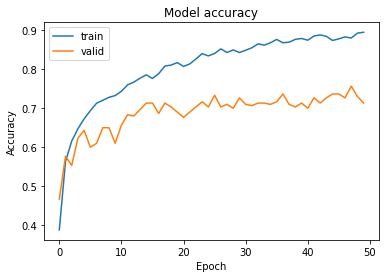

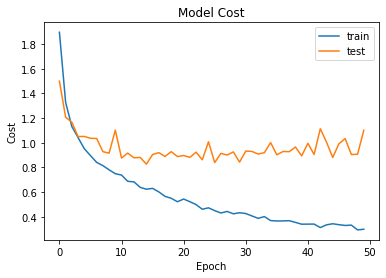

In [17]:
# Create plots for Model Accuracy and Model Cost
plt.plot(result.history['accuracy'], label='train') #training accuracy
plt.plot(result.history['val_accuracy'], label='valid') #validation accuracy
plt.legend(loc='upper left') #show a ledgend for line colour in the upper left corner
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

plt.plot(result.history['loss'], label='train')
plt.plot(result.history['val_loss'], label='test')
plt.legend(loc='upper right')
plt.title('Model Cost')
plt.ylabel('Cost')
plt.xlabel('Epoch')
plt.show()

We have started by building a basic model, using the pretrained Xception base and a new classification layer.  
It learns well with training accuracy reaching almost 90% and validation accuracy at a consistent 70%. 

However after about 20 epochs, the validation accuracy does not increase any more and the model is overfitting. The validation cost of the model also stops decreasing after 15/20 epochs.

To reduce this overfitting we can adjust some of the parameters of the model.



# MODEL 2

In [10]:
# Create model 2 with the same structure the same as model 1.
model2 = model

# Compile model with optimiser, loss and metrics
model2.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.005), #Increase the learning rate from 0.001 to 0.005
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics = ['accuracy'])

Introduce callbacks for learning rate reduction and early stopping if no improvement in validation loss is seen.

In [9]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor = 'val_loss', # monitor validation loss for improvements
    factor = 0.5, # the factor that the learning rate will be multiplied by to decrease it
    patience = 3, # after 3 epochs the learning rate will be decreased
    min_lr = 0.0005, # the minimum learning rate that the model can go to
    verbose = 1) # set verbose to 1 so its visible

early_stop = tf.keras.callbacks.EarlyStopping(
              monitor = 'val_loss', # also monitor validation loss for improvements
              patience = 10, # patience of 10 epochs before early stopping
              verbose = 1) # make visible

In [14]:
# Fit the model using the training data
result2 = model2.fit(train_generator,
                    epochs = 50,
                    verbose = 1,
                    validation_data = val_generator,
                    callbacks = [reduce_lr, early_stop]) # include the callbacks in the model.fit

Epoch 1/50
155/155 [==============================] - 52s 303ms/step - loss: 2.1094 - accuracy: 0.3220 - val_loss: 1.3620 - val_accuracy: 0.4833
Epoch 2/50
155/155 [==============================] - 46s 297ms/step - loss: 1.2718 - accuracy: 0.5646 - val_loss: 1.1252 - val_accuracy: 0.5867
Epoch 3/50
155/155 [==============================] - 46s 297ms/step - loss: 1.1726 - accuracy: 0.5849 - val_loss: 1.1558 - val_accuracy: 0.5700
Epoch 4/50
155/155 [==============================] - 46s 297ms/step - loss: 1.0401 - accuracy: 0.6311 - val_loss: 1.0350 - val_accuracy: 0.6367
Epoch 5/50
155/155 [==============================] - 47s 303ms/step - loss: 1.0005 - accuracy: 0.6513 - val_loss: 1.0259 - val_accuracy: 0.6167
Epoch 6/50
155/155 [==============================] - 46s 299ms/step - loss: 0.9220 - accuracy: 0.6700 - val_loss: 0.9921 - val_accuracy: 0.6367
Epoch 7/50
155/155 [==============================] - 46s 298ms/step - loss: 0.8758 - accuracy: 0.6948 - val_loss: 0.8850 - val_ac

The early stopping function stops training after 31 epochs as no improvements in validation loss were seen. 

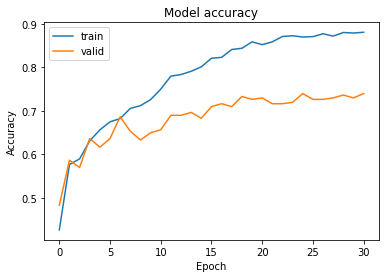

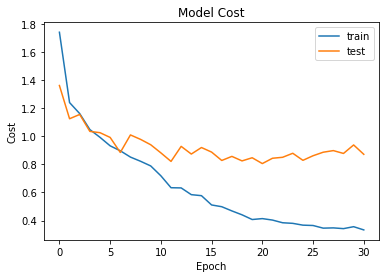

In [15]:
# Create plots for Model Accuracy and Model Cost
plt.plot(result2.history['accuracy'], label='train') #training accuracy
plt.plot(result2.history['val_accuracy'], label='valid') #validation accuracy
plt.legend(loc='upper left') #show a ledgend for line colour in the upper left corner
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

plt.plot(result2.history['loss'], label='train')
plt.plot(result2.history['val_loss'], label='test')
plt.legend(loc='upper right')
plt.title('Model Cost')
plt.ylabel('Cost')
plt.xlabel('Epoch')
plt.show()

Changing the learning rate has improved validation accuracy slightly to around 74%. However there is still the problem of overfitting that needs to be solved.

# MODEL 3

Data augmentation is the artificial production of more data for training when we have a small data set, although we have more data that we have not used yet, it will be interesting to see if this improves accuracy over the same number of epochs or not.

There are many data augmentation options, however the idea of this model is to correctly distinguish between different plant species, so by changing the images too much or distorting them it will not help. The chosen augmentation options are only those that will keep the image in the correct shape to aid with correct identification of plants.

In [10]:
# Rescale images 
train_datagen3 = ImageDataGenerator(
      rescale = 1/255, # this rescales the images so the values are between 0 and 1
      horizontal_flip = True, 
      vertical_flip = True,
      brightness_range = [0.5, 1.5]) # darkens or lightens the image each way by 50%

val_datagen3 = ImageDataGenerator(
    rescale = 1/255, 
      horizontal_flip = True, 
      vertical_flip = True,
      brightness_range = [0.5, 1.5])

In [11]:
# Generate images for model
print("Total images in training data set:")
train_generator3 = train_datagen3.flow_from_directory(
    train_data_path,
    target_size = (150, 150),
    color_mode = "rgb",
    classes = species,
    class_mode = "categorical",
    batch_size = 32,
    shuffle = True
)

print("Total images in validation data set")
val_generator3 = val_datagen3.flow_from_directory(
    val_data_path,
    target_size = (150, 150),
    color_mode = "rgb",
    classes = species,
    class_mode = "categorical",
    batch_size = 32,
    shuffle = True
)

Total images in training data set:
Found 4939 images belonging to 12 classes.
Total images in validation data set
Found 300 images belonging to 12 classes.


In [12]:
# Create adjusted model 
model3 = model


In [13]:
# Compile model with optimiser, loss and metrics. These are the same as model 2.
model3.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.005),
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics = ['accuracy'])

In [16]:
# Fit the model using the training data
result3 = model3.fit(train_generator3,
                    epochs = 50,
                    verbose = 1,
                    validation_data = val_generator3,
                    callbacks = [reduce_lr, early_stop])

Epoch 1/50
155/155 [==============================] - 57s 335ms/step - loss: 2.0789 - accuracy: 0.3262 - val_loss: 1.2851 - val_accuracy: 0.5600
Epoch 2/50
155/155 [==============================] - 51s 324ms/step - loss: 1.2650 - accuracy: 0.5694 - val_loss: 1.0977 - val_accuracy: 0.6200
Epoch 3/50
155/155 [==============================] - 51s 329ms/step - loss: 1.1134 - accuracy: 0.6096 - val_loss: 1.1282 - val_accuracy: 0.6033
Epoch 4/50
155/155 [==============================] - 51s 327ms/step - loss: 1.0865 - accuracy: 0.6186 - val_loss: 0.9529 - val_accuracy: 0.6200
Epoch 5/50
155/155 [==============================] - 51s 332ms/step - loss: 1.0091 - accuracy: 0.6454 - val_loss: 1.0570 - val_accuracy: 0.6000
Epoch 6/50
155/155 [==============================] - 52s 333ms/step - loss: 1.0374 - accuracy: 0.6423 - val_loss: 0.9308 - val_accuracy: 0.6767
Epoch 7/50
155/155 [==============================] - 51s 330ms/step - loss: 0.9471 - accuracy: 0.6689 - val_loss: 0.9778 - val_ac

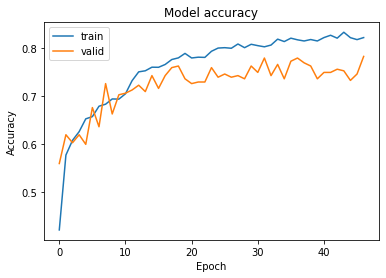

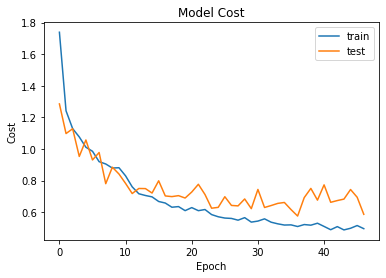

In [17]:
plt.plot(result3.history['accuracy'], label='train')
plt.plot(result3.history['val_accuracy'], label='valid')
plt.legend(loc='upper left')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()
plt.plot(result3.history['loss'], label='train')
plt.plot(result3.history['val_loss'], label='test')
plt.legend(loc='upper right')
plt.title('Model Cost')
plt.ylabel('Cost')
plt.xlabel('Epoch')
plt.show()

Image augmentation decreases the difference between training and validation accuracy is greatly reduced. This is good because it means the model is performing almost as well on unseen data as it is on training data. The validation accuracy is now also around 75%.

# MODEL 4

Keeping the Image Augmentation in the model as this improved the problem of overfitting, lets now try to apply the pretrained weight from the 'ImageNet' data set to the pretrained base and see if this alters model performance. Before we had assigned the weights they were just being randomly generated using training data.

In [12]:
# define pretrained Xception base
pretrained_base4 = xception.Xception(input_shape=[150, 150, 3],
                                     weights = 'imagenet',
                                     include_top=False)
pretrained_base4.trainable = False

In [15]:
# Create full model with new densely connected classifier
model4 = tf.keras.Sequential([
    pretrained_base4, # this is the pretrained Xception base from above 
    tf.keras.layers.GlobalMaxPooling2D(),
    tf.keras.layers.Dense(100, activation = "relu"),
    tf.keras.layers.BatchNormalization(trainable = True, axis = 1),
    
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Dense(50, activation = "relu"),
    tf.keras.layers.BatchNormalization(trainable = True, axis = 1),
    
    tf.keras.layers.Dense(12,activation = 'softmax') # this should be number of classes?
])

In [16]:
# Compile model with optimiser, loss and metrics
model4.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.005),
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics = ['accuracy'])

In [18]:
# Fit the model using the training data
result = model4.fit(train_generator3,
                    epochs = 50,
                    verbose = 1,
                    validation_data = val_generator3,
                    callbacks = [reduce_lr, early_stop])

Epoch 1/50
155/155 [==============================] - 59s 346ms/step - loss: 1.9947 - accuracy: 0.3552 - val_loss: 1.2766 - val_accuracy: 0.5367
Epoch 2/50
155/155 [==============================] - 52s 336ms/step - loss: 1.2877 - accuracy: 0.5603 - val_loss: 1.1467 - val_accuracy: 0.5900
Epoch 3/50
155/155 [==============================] - 51s 328ms/step - loss: 1.1740 - accuracy: 0.5878 - val_loss: 1.0490 - val_accuracy: 0.5933
Epoch 4/50
155/155 [==============================] - 51s 327ms/step - loss: 1.1007 - accuracy: 0.6251 - val_loss: 0.9165 - val_accuracy: 0.6533
Epoch 5/50
155/155 [==============================] - 51s 327ms/step - loss: 1.0103 - accuracy: 0.6533 - val_loss: 0.9724 - val_accuracy: 0.6200
Epoch 6/50
155/155 [==============================] - 50s 325ms/step - loss: 0.9892 - accuracy: 0.6569 - val_loss: 0.9362 - val_accuracy: 0.6600
Epoch 7/50
155/155 [==============================] - 51s 326ms/step - loss: 1.0049 - accuracy: 0.6558 - val_loss: 0.9651 - val_ac

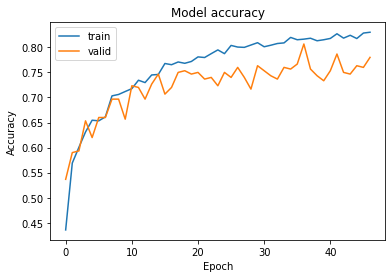

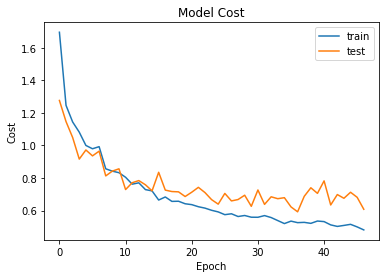

In [19]:
plt.plot(result.history['accuracy'], label='train')
plt.plot(result.history['val_accuracy'], label='valid')
plt.legend(loc='upper left')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()
plt.plot(result.history['loss'], label='train')
plt.plot(result.history['val_loss'], label='test')
plt.legend(loc='upper right')
plt.title('Model Cost')
plt.ylabel('Cost')
plt.xlabel('Epoch')
plt.show()

There is much closer accuracy between the training and the validation sets. and overall validation accuracy has been increased by using the ImageNet weights.

Next we can look into the structure of the densely connected head of the model to see if any improvements in accuracy can be made. The model will still use the weights from ImageNet and the data augmentation as these improved model performance.

# MODEL 5

In [13]:
# Create full model with new densely connected classifier
model5 = tf.keras.Sequential([
    pretrained_base4, # this is the pretrained Xception base from above 
    tf.keras.layers.GlobalMaxPooling2D(),
    tf.keras.layers.Dense(256, activation = "relu"),
    tf.keras.layers.BatchNormalization(trainable = True, axis = -1),
    
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Dense(128, activation = "relu"),
    tf.keras.layers.BatchNormalization(trainable = True, axis = -1),
    
    tf.keras.layers.Dense(12,activation = 'softmax') # this should be number of classes?
])

In [14]:
# Compile model with optimiser, loss and metrics
model5.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.005),
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics = ['accuracy'])

In [15]:
# Fit the model using the training data
result5 = model5.fit(train_generator3,
                    epochs = 50,
                    verbose = 1,
                    validation_data = val_generator3,
                    callbacks = [reduce_lr, early_stop])

Epoch 1/50
155/155 [==============================] - 60s 351ms/step - loss: 1.9258 - accuracy: 0.3980 - val_loss: 1.2703 - val_accuracy: 0.5367
Epoch 2/50
155/155 [==============================] - 54s 350ms/step - loss: 1.1705 - accuracy: 0.5896 - val_loss: 1.0852 - val_accuracy: 0.6033
Epoch 3/50
155/155 [==============================] - 53s 340ms/step - loss: 1.0559 - accuracy: 0.6278 - val_loss: 1.0101 - val_accuracy: 0.6167
Epoch 4/50
155/155 [==============================] - 53s 343ms/step - loss: 0.9948 - accuracy: 0.6557 - val_loss: 0.8723 - val_accuracy: 0.6633
Epoch 5/50
155/155 [==============================] - 53s 343ms/step - loss: 0.9431 - accuracy: 0.6714 - val_loss: 0.9779 - val_accuracy: 0.6500
Epoch 6/50
155/155 [==============================] - 53s 342ms/step - loss: 0.8685 - accuracy: 0.6924 - val_loss: 0.8392 - val_accuracy: 0.7100
Epoch 7/50
155/155 [==============================] - 53s 341ms/step - loss: 0.8515 - accuracy: 0.7037 - val_loss: 0.8651 - val_ac

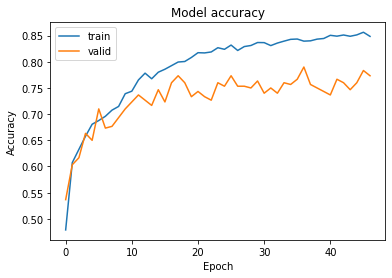

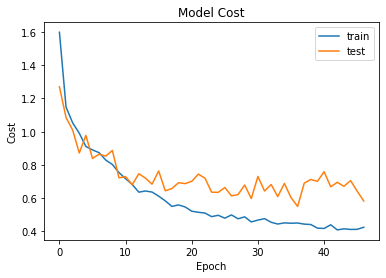

In [16]:
plt.plot(result5.history['accuracy'], label='train')
plt.plot(result5.history['val_accuracy'], label='valid')
plt.legend(loc='upper left')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

plt.plot(result5.history['loss'], label='train')
plt.plot(result5.history['val_loss'], label='test')
plt.legend(loc='upper right')
plt.title('Model Cost')
plt.ylabel('Cost')
plt.xlabel('Epoch')
plt.show()

# Training and Testing with 6 Species 

In [18]:
# Define directories for training and test images
all_images = '/content/drive/MyDrive/Harper/3-C7082/Assignment/C7082-assignment/6-data'

half_train_data_path = os.path.join(all_images, 'train/')
half_test_data_path = os.path.join(all_images, 'test/')
half_val_data_path = os.path.join(all_images, 'validation/')


There are now more images per class for training.

In [19]:
half_list_paths = glob.glob(half_train_data_path + '*')
half_species = [i.replace(half_train_data_path,'') for i in half_list_paths]
print(half_species)


['bgs', 'chk', 'cls', 'wht', 'mze', 'sbt']


In [20]:
for i in half_species:
    print(i + ': ' + str(len(os.listdir(half_train_data_path + i))) + ' pictures')

bgs: 200 pictures
chk: 200 pictures
cls: 200 pictures
wht: 200 pictures
mze: 200 pictures
sbt: 200 pictures


In [21]:
half_list_paths = glob.glob(half_train_data_path + '*')
half_species = [i.replace(half_train_data_path,'') for i in half_list_paths]
print(half_species)

['bgs', 'chk', 'cls', 'wht', 'mze', 'sbt']


In [22]:
test_datagen = ImageDataGenerator(
      rescale = 1/255,
      width_shift_range=0.2, 
      height_shift_range=0.2, 
      shear_range=0.2, 
      zoom_range=0.2, 
      horizontal_flip=True, 
      fill_mode='nearest')



In [24]:
# Generate images for model
print("Total images in training data set:")
train_generator_half = train_datagen7.flow_from_directory(
    half_train_data_path,
    target_size = (100, 100),
    color_mode = "rgb",
    classes = half_species,
    class_mode = "categorical",
    batch_size = 32,
    shuffle = True
)

print("Total images in validation data set")
val_generator_half = val_datagen7.flow_from_directory(
    half_val_data_path,
    target_size = (100, 100),
    color_mode = "rgb",
    classes = half_species,
    class_mode = "categorical",
    batch_size = 32,
    shuffle = True
)

print("Total images in test data set")
test_generator_half = test_datagen.flow_from_directory(
    half_test_data_path,
    target_size = (100, 100),
    color_mode = "rgb",
    classes = half_species,
    class_mode = "categorical",
    batch_size = 32,
    shuffle = True
)

Total images in training data set:
Found 1200 images belonging to 6 classes.
Total images in validation data set
Found 150 images belonging to 6 classes.
Total images in test data set
Found 150 images belonging to 6 classes.


In [31]:
# Create adjusted model 
model_half = tf.keras.Sequential([
    pretrained_base7, # this is the pretrained Xception base from above 
    tf.keras.layers.GlobalMaxPooling2D(),
    tf.keras.layers.Dense(100, activation = "relu"),
    tf.keras.layers.BatchNormalization(trainable = True, axis = 1),
    
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Dense(50, activation = "relu"),
    tf.keras.layers.BatchNormalization(trainable = True, axis = 1),
    
    tf.keras.layers.Dense(6, activation = 'softmax') # this should be number of classes?
])


In [32]:
# Compile model with optimiser, loss and metrics
model_half.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.005),
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics = ['accuracy'])

In [33]:
reduce_lr7 = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 3,
                              verbose = 1, 
                              min_lr = 0.0001)

early_stop7 = tf.keras.callbacks.EarlyStopping(
              monitor = 'val_loss', patience = 10, verbose = 1)

In [34]:
# Fit the model using the training data
result_half = model_half.fit(train_generator_half,
                    epochs = 50,
                    verbose = 1,
                    validation_data = val_generator_half,
                    callbacks = [reduce_lr7, early_stop7])

Epoch 1/50
38/38 [==============================] - 340s 9s/step - loss: 1.8159 - accuracy: 0.3199 - val_loss: 1.5664 - val_accuracy: 0.4333
Epoch 2/50
38/38 [==============================] - 62s 2s/step - loss: 1.2909 - accuracy: 0.4873 - val_loss: 1.2873 - val_accuracy: 0.4867
Epoch 3/50
38/38 [==============================] - 60s 2s/step - loss: 1.1892 - accuracy: 0.5287 - val_loss: 1.0279 - val_accuracy: 0.5667
Epoch 4/50
38/38 [==============================] - 60s 2s/step - loss: 1.1821 - accuracy: 0.5257 - val_loss: 1.0281 - val_accuracy: 0.5733
Epoch 5/50
38/38 [==============================] - 60s 2s/step - loss: 1.0954 - accuracy: 0.5599 - val_loss: 1.0017 - val_accuracy: 0.6000
Epoch 6/50
38/38 [==============================] - 61s 2s/step - loss: 0.9998 - accuracy: 0.5864 - val_loss: 0.9531 - val_accuracy: 0.6267
Epoch 7/50
38/38 [==============================] - 60s 2s/step - loss: 1.0154 - accuracy: 0.5692 - val_loss: 0.9371 - val_accuracy: 0.6133
Epoch 8/50
38/38 [=

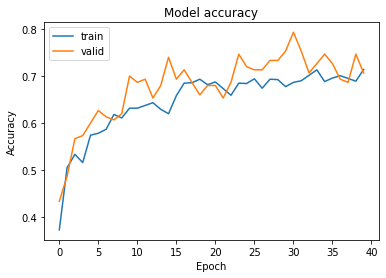

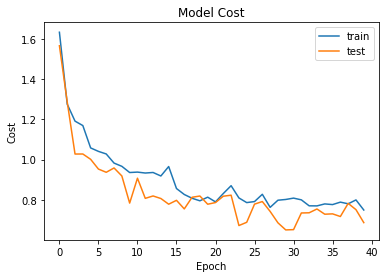

In [35]:
plt.plot(result_half.history['accuracy'], label='train')
plt.plot(result_half.history['val_accuracy'], label='valid')
plt.legend(loc='upper left')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()
plt.plot(result_half.history['loss'], label='train')
plt.plot(result_half.history['val_loss'], label='test')
plt.legend(loc='upper right')
plt.title('Model Cost')
plt.ylabel('Cost')
plt.xlabel('Epoch')
plt.show()

In [42]:
test_half_evaluate = model_half.evaluate(test_datagen.flow_from_directory(half_test_data_path,
                                                        target_size=(100, 100), 
                                                        color_mode='rgb',
                                                        class_mode='categorical'))

Found 150 images belonging to 6 classes.
5/5 [==============================] - 7s 1s/step - loss: 2.7801 - accuracy: 0.3933


In [44]:
print('Test Loss, Test Accuracy:', test_half_evaluate)

Test Loss, Test Accuracy: [2.7801032066345215, 0.3933333456516266]


In [45]:
a = test_datagen.flow_from_directory(half_test_data_path,
                                    target_size=(100, 100), 
                                    color_mode='rgb',
                                    class_mode='categorical',
                                    batch_size=1)

Found 150 images belonging to 6 classes.


In [46]:
species_a = list(a.class_indices.keys())

In [47]:
R_categories = {y:x for x,y in a.class_indices.items()}
R_categories

{0: 'bgs', 1: 'chk', 2: 'cls', 3: 'mze', 4: 'sbt', 5: 'wht'}